### Importing neccessary libraries

In [1]:
import torch
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
import zipfile as zf
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
from torchvision.models import resnet18
from tqdm import tqdm
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shutil
import random
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score

### Importing and Extracting zip file

In [2]:
files = zf.ZipFile("satellite_image_data.zip", 'r')
files.extractall('train')
files.close()

### Visualizing the image of each class

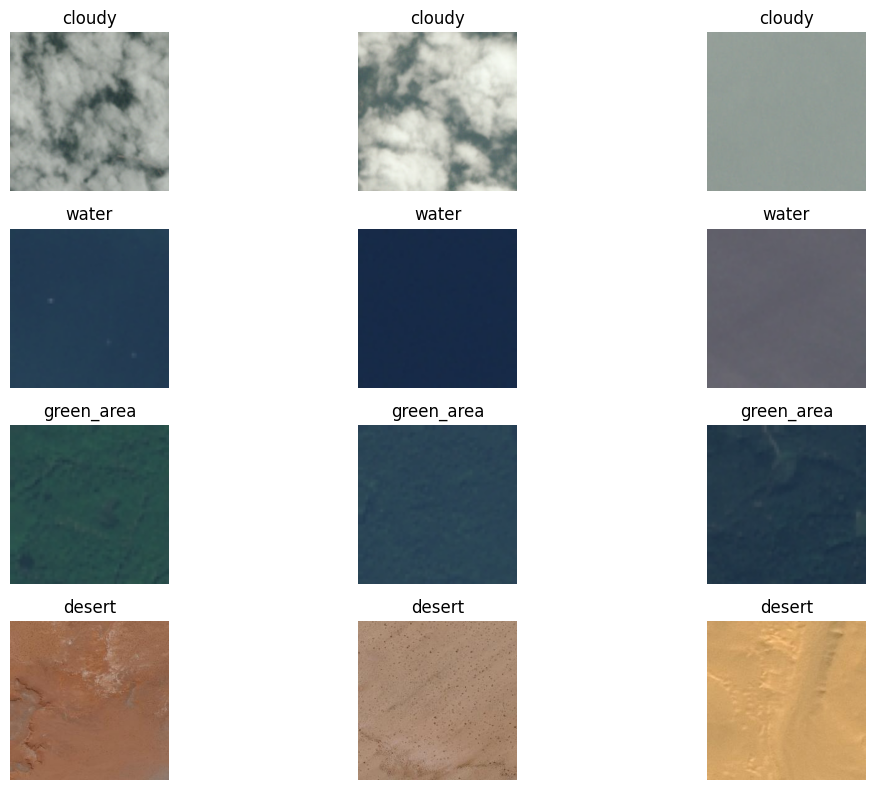

In [3]:
# Define the folders containing images for each class
class_folders = ["cloudy", "water", "green_area", "desert"]

# Number of images to visualize from each class
num_images_per_class = 3

# Set up subplots
fig, axes = plt.subplots(nrows=len(class_folders), ncols=num_images_per_class, figsize=(12, 8))

# Loop through each class folder
for i,class_name in enumerate(class_folders):
    # Get the list of image files in the class folder
    image_files = os.listdir(os.path.join("train/satellite_image_data", class_name))

    # Select a subset of images from the class
    selected_images = image_files[:num_images_per_class]

    for j, img_file in enumerate(selected_images):
        # Load and display the image
        img_path = os.path.join("train/satellite_image_data", class_name, img_file)
        img = mpimg.imread(img_path)

        # Plot the image
        axes[i, j].imshow(img)
        axes[i, j].set_title(class_name)
        axes[i, j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


### Checking the channel mode of the image

In [4]:
image_path='/content/train/satellite_image_data/cloudy/train_10021.jpg'
# Path to the image file
image = PIL.Image.open(image_path)
print(f"Image mode: {image.mode}")


Image mode: CMYK


### Converting the CMYK channel to RBG channel for each image

In [5]:
def convert_to_rgb(folder_path):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpg"):  # all images are JPG format
                file_path = os.path.join(root, file)
                cmyk_image = Image.open(file_path)
                # Convert CMYK to RGB
                rgb_image = cmyk_image.convert("RGB")
                # Save the RGB image, overwrite the original
                rgb_image.save(file_path)

# Define the paths to the train and test folders
train_folder = "train/satellite_image_data"

# Convert images in the train folder to RGB
convert_to_rgb(train_folder)

### Checking the mode of the image after conversion

In [6]:
image_path='/content/train/satellite_image_data/cloudy/train_10224.jpg'
# Path to the image file
image = PIL.Image.open(image_path)
siz= image.size
print(f"Image size: {siz}")
print(f"Image mode: {image.mode}")

Image size: (256, 256)
Image mode: RGB


### Visualizing the size of each class

Class: cloudy, Size: 1500
Class: desert, Size: 1131
Class: green_area, Size: 1500
Class: water, Size: 1500


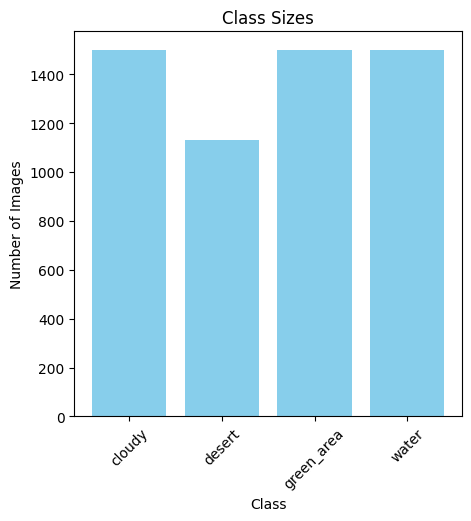

In [7]:
# Path to the parent folder containing the class folders
train_folder = 'train/satellite_image_data'
# Initialize a dictionary to store the size of each class
class_sizes = {}

# Iterate over the class folders
for class_name in os.listdir(train_folder):
    class_folder = os.path.join(train_folder, class_name)
    if os.path.isdir(class_folder):
        # Count the number of files (images) in the class folder
        num_images = len(os.listdir(class_folder))
        class_sizes[class_name] = num_images

# Print the size of each class
for class_name, size in class_sizes.items():
    print(f"Class: {class_name}, Size: {size}")

# Extract class names and sizes
class_names = list(class_sizes.keys())
sizes = list(class_sizes.values())

# Plot the bar chart
plt.figure(figsize=(5, 5))
plt.bar(class_names, sizes, color='skyblue')
plt.title('Class Sizes')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


### Transformation

In [9]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define mean and standard deviation
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

# Define transformations for training data with augmentation
aug_transform = transforms.Compose([
    transforms.Resize(224),  # Resize the image to 224x224
    transforms.RandomHorizontalFlip(), # flip the image horizontally
    transforms.RandomRotation(10),       # rotate the image by up to 10 degrees
    transforms.ToTensor(),               # Convert the image to a tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize the image with the predefined mean and standard deviation
])

transform = transforms.Compose([ transforms.RandomResizedCrop(224),  # Randomly crop the image and resize to 224x224,
                                transforms.ToTensor(),               # Convert the image to a tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize the image with the predefined mean and standard deviation
])


Using device: cuda


### Splitting data to train, validation and test data after augmentation

In [10]:
# Path to the parent folder containing the class folders
train_folder = 'train/satellite_image_data'

# Path to the folder containing the desert images
desert_folder = os.path.join(train_folder, 'desert')
print(desert_folder)

# List all the image files in the desert folder
desert_images = [f for f in os.listdir(desert_folder) if os.path.isfile(os.path.join(desert_folder, f))]

# Calculate the number of images currently in the desert folder
current_desert_samples = 1131

# Define the desired number of samples for the desert class
desired_desert_samples = 1500

# Calculate the number of additional samples needed
additional_samples_needed = desired_desert_samples - current_desert_samples

# Augment the dataset by randomly selecting images from the desert folder and applying transformations
for i in range(additional_samples_needed):
    # Randomly select an image from the desert folder
    random_image = random.choice(desert_images)
    image_path = os.path.join(desert_folder, random_image)

    # Open the image
    with Image.open(image_path) as img:
       # Apply transformations
        transformed_image = aug_transform(img)

        # Generate a new filename for the augmented image
        new_filename = f"desert_{i+1000}_{random_image}"
        new_image_path = os.path.join(desert_folder, new_filename)

        # Save the augmented image
        transforms.ToPILImage()(transformed_image).save(new_image_path)

# Print the number of images in the augmented desert folder
augmented_desert_images = os.listdir(desert_folder)
print("Number of augmented images in the desert folder:", len(augmented_desert_images))

# Create the ImageFolder dataset with augmentation for training
train_dataset_org = ImageFolder(train_folder, transform=transform)
aug_train_dataset1 = ImageFolder(train_folder, transform=aug_transform)

# Concatenate the datasets
concatenated_dataset = ConcatDataset([train_dataset_org, aug_train_dataset1])

# Define the percentage of data to be used for validation and testing
validation_ratio = 0.20  # 20% of the data will be used for validation
test_ratio = 0.20        # 20% of the data will be used for testing

# Calculate the number of samples for training, validation, and testing
num_samples = len(concatenated_dataset)
num_validation_samples = int(validation_ratio * num_samples)
num_test_samples = int(test_ratio * num_samples)
num_training_samples = num_samples - num_validation_samples - num_test_samples

# Split the dataset into training, validation, and test sets
train_dataset, validation_dataset, test_dataset = random_split(concatenated_dataset, [num_training_samples, num_validation_samples, num_test_samples])

# Create DataLoaders for training, validation, and test data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Total number of samples:", num_samples)
print("Number of training samples:", num_training_samples)
print("Number of validation samples:", num_validation_samples)
print("Number of test samples:", num_test_samples)

train/satellite_image_data/desert
Number of augmented images in the desert folder: 1500
Total number of samples: 12000
Number of training samples: 7200
Number of validation samples: 2400
Number of test samples: 2400


In [11]:
# Create a dictionary for each type of label
labels={0:'cloudy',1:'desert',2:'green_area',3:'water'}

### Define the CNN model

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 28 * 28, 224),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(224, num_classes)  # Corrected the number of input features here
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize the CNN model
model = CNN(num_classes=4)

# Print the model architecture
print(model)


CNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=50176, out_features=224, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=224, out_features=4, bias=True)
  )
)


### Train the model

In [15]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)
# Train the model
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * inputs.size(0)

        # Update total number of samples
        train_total += labels.size(0)

        # Get predictions
        _, predicted = torch.max(outputs, 1)

        # Update number of correct predictions
        train_correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / len(train_dataset)
    train_accuracy = train_correct / train_total

    # Initialize variables to compute validation loss and accuracy
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            # Update total number of samples
            val_total += labels.size(0)

            # Update number of correct predictions
            val_correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    val_loss = val_running_loss / len(validation_dataset)
    val_accuracy = val_correct / val_total

    # Append statistics to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print statistics
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Training completed!")


Epoch 1/10, Training Loss: 0.6519, Training Accuracy: 0.6490, Validation Loss: 0.0159, Validation Accuracy: 0.6933
Epoch 2/10, Training Loss: 0.4939, Training Accuracy: 0.7186, Validation Loss: 0.0154, Validation Accuracy: 0.7212
Epoch 3/10, Training Loss: 0.4573, Training Accuracy: 0.7474, Validation Loss: 0.0146, Validation Accuracy: 0.7171
Epoch 4/10, Training Loss: 0.4237, Training Accuracy: 0.7768, Validation Loss: 0.0129, Validation Accuracy: 0.7804
Epoch 5/10, Training Loss: 0.4294, Training Accuracy: 0.7760, Validation Loss: 0.0132, Validation Accuracy: 0.7900
Epoch 6/10, Training Loss: 0.4253, Training Accuracy: 0.7897, Validation Loss: 0.0143, Validation Accuracy: 0.7392
Epoch 7/10, Training Loss: 0.4307, Training Accuracy: 0.7958, Validation Loss: 0.0118, Validation Accuracy: 0.8600
Epoch 8/10, Training Loss: 0.4408, Training Accuracy: 0.7853, Validation Loss: 0.0122, Validation Accuracy: 0.8325
Epoch 9/10, Training Loss: 0.3925, Training Accuracy: 0.8243, Validation Loss: 0

### Evaluation of the model

In [16]:
model.eval()
y_true = []
y_pred = []
# Total number of correct predictions
correct_predictions = 0
with torch.no_grad():
    # Move the model to the same device as the inputs
    model.to(device)
    # Iterate over test data
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        # Update the number of correct predictions
        correct_predictions += (predicted == labels).sum().item()

# Calculate the total number of samples
total_samples = len(y_true)

# Calculate the accuracy
accuracy = correct_predictions / total_samples
print('Accuracy of the test data: {:.2f}%'.format(100 * accuracy))

# Calculate precision
precision = precision_score(y_true, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_true, y_pred, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy of the test data: 82.58%
Precision: 0.8276399905603741
Recall: 0.8258333333333333
F1 Score: 0.8260443744552465


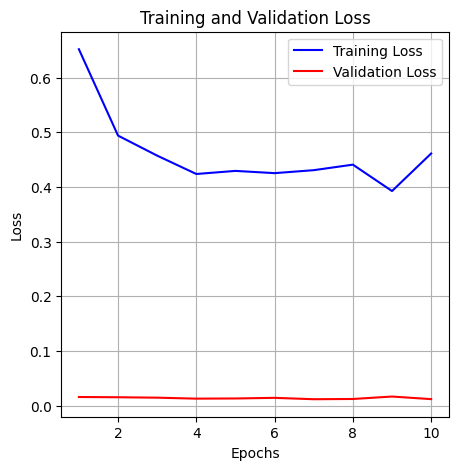

In [17]:
# Plot loss
plt.figure(figsize=(5, 5))
plt.plot(range(1, num_epochs + 1), train_losses, 'b', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

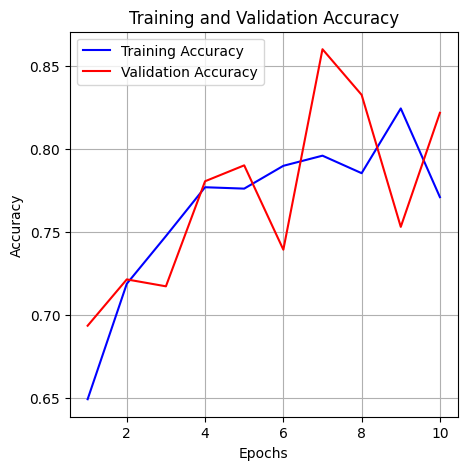

In [18]:
# Plot accuracy
plt.figure(figsize=(5, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, 'b', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
labels = {0 : "cloudy", 1: "desert", 2: "green_area", 3: "water"}

### Created confusion matrix

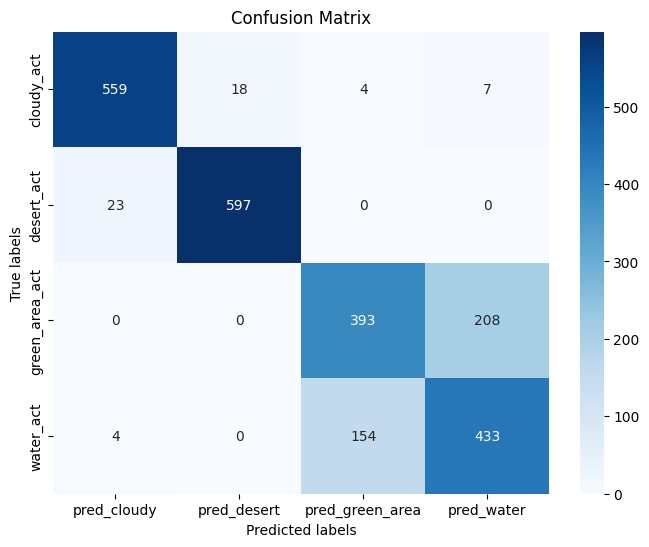

In [19]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["pred_cloudy", "pred_desert", "pred_green_area", "pred_water"], yticklabels=['cloudy_act','desert_act','green_area_act','water_act'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Test the model

https://www.sciotopost.com/weather-plenty-clouds-cool-temperatures-today/

Predicted label: desert


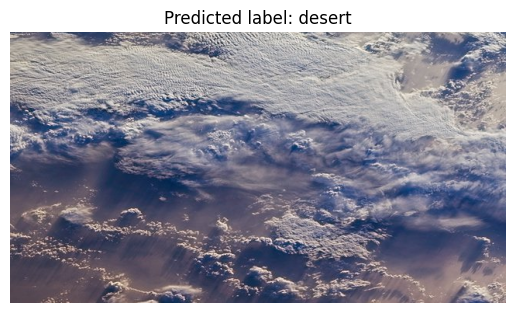

In [22]:
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

# Assuming 'model' is your PyTorch model object

# Load and preprocess the unseen image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image
image = Image.open('cloudy-1.jpg')

# Resize the image
resized_image = image.resize((224, 224))  # Resize to match the input size expected by your model

# Transform the image
input_image = transform(resized_image).unsqueeze(0)  # Add batch dimension
# Move the input tensor to the same device as the model
input_image = input_image.to(device)
# Pass the input image through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(input_image)

# Get the predicted label
predictions = torch.argmax(output, dim=1)
predicted_label = predictions.item()

print("Predicted label:", labels[predicted_label])
# Visualize the image
plt.imshow(image)
plt.axis('off')
plt.title('Predicted label: {}'.format(labels[predicted_label]))
plt.show()

https://fineartamerica.com/featured/satellite-view-of-desert-area-panoramic-images.html

Predicted label: desert


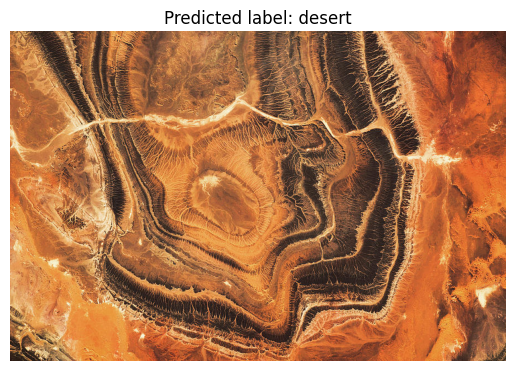

In [25]:
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

# Assuming 'model' is your PyTorch model object

# Load and preprocess the unseen image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image
image = Image.open('desert-1.jpg')

# Resize the image
resized_image = image.resize((224, 224))  # Resize to match the input size expected by your model

# Transform the image
input_image = transform(resized_image).unsqueeze(0)  # Add batch dimension
# Move the input tensor to the same device as the model
input_image = input_image.to(device)
# Pass the input image through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(input_image)

# Get the predicted label
predictions = torch.argmax(output, dim=1)
predicted_label = predictions.item()

print("Predicted label:", labels[predicted_label])

# Visualize the image
plt.imshow(image)
plt.axis('off')
plt.title('Predicted label: {}'.format(labels[predicted_label]))
plt.show()


https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.nationalgeographic.com%2Fscience%2Farticle%2F130619-vegetation-green-earth-science-technology-environment&psig=AOvVaw2ctqAyodZip3Uwhek2Eyf-&ust=1712247175819000&source=images&cd=vfe&opi=89978449&ved=0CBIQjRxqFwoTCMi50Pm3poUDFQAAAAAdAAAAABAE

Predicted label: green_area


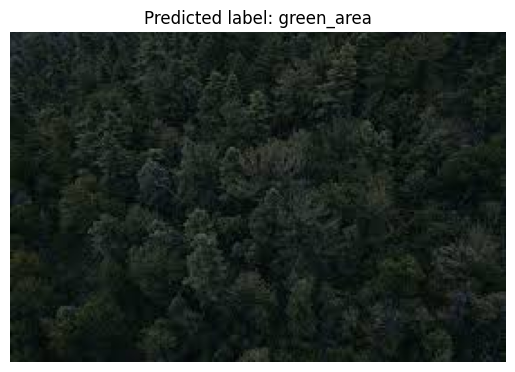

In [26]:
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

# Assuming 'model' is your PyTorch model object

# Load and preprocess the unseen image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image
image = Image.open('green_area1.jpg')

# Resize the image
resized_image = image.resize((224, 224))  # Resize to match the input size expected by your model

# Transform the image
input_image = transform(resized_image).unsqueeze(0)  # Add batch dimension
# Move the input tensor to the same device as the model
input_image = input_image.to(device)
# Pass the input image through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(input_image)

# Get the predicted label
predictions = torch.argmax(output, dim=1)
predicted_label = predictions.item()

print("Predicted label:", labels[predicted_label])
# Visualize the image
plt.imshow(image)
plt.axis('off')
plt.title('Predicted label: {}'.format(labels[predicted_label]))
plt.show()



https://www.google.com/imgres?imgurl=https%3A%2F%2Fcdn.openart.ai%2Fstable_diffusion%2F08d598d672097d65d7ff1fa9e9455e2114d5560d_2000x2000.webp&tbnid=EeovhH4hdCU1aM&vet=10CBAQxiAoA2oXChMI6MmstJ6lhQMVAAAAAB0AAAAAEA8..i&imgrefurl=https%3A%2F%2Fopenart.ai%2Fdiscovery%2Fsd-1007375181817331813&docid=XdRvjT6530bSpM&w=1024&h=1024&itg=1&q=ocean%20satellite%20view&hl=en&ved=0CBAQxiAoA2oXChMI6MmstJ6lhQMVAAAAAB0AAAAAEA8

Predicted label: desert


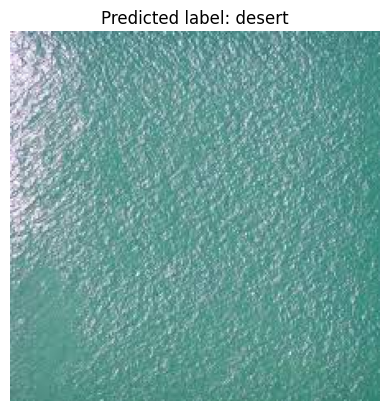

In [29]:
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

# Assuming 'model' is your PyTorch model object

# Load and preprocess the unseen image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image
image = Image.open('water3.png')

# Resize the image
resized_image = image.resize((224, 224))  # Resize to match the input size expected by your model

# Transform the image
input_image = transform(resized_image).unsqueeze(0)  # Add batch dimension
# Move the input tensor to the same device as the model
input_image = input_image.to(device)
# Pass the input image through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(input_image)

# Get the predicted label
predictions = torch.argmax(output, dim=1)
predicted_label = predictions.item()

print("Predicted label:", labels[predicted_label])
# Visualize the image
plt.imshow(image)
plt.axis('off')
plt.title('Predicted label: {}'.format(labels[predicted_label]))
plt.show()

